# Python and Cython speed-up of hyperct code


This notebook is dedicated to transforming the hyperct code into Cython classes and methods with the following enhancements:

1. Conversion of Python methods into Cython, incorporating typed functions to enhance performance and efficiency.
2. Introduction of a list alongside the existing dictionary cache to optimize iteration over the vertices of the complex.
3. Implementation of nogil and prange for better concurrency and parallel processing capabilities.

Important modifications and notes:

- The `refine_all_star()` method has been restructured as a separate function, independent of the `Complex()` class. This modification facilitates isolated testing without requiring the entire class.
- To effectively translate the `refine_all_star()` method into Cython, it is essential to also convert `VertexCacheIndex` and V`ertexCube` to Cython. This process involves not only replicating the cache but also accurately transferring the connections (neighbours). The `python_to_cython_vertex` function, utilizing a breadth-first approach, is employed for this purpose.
- Testing is conducted to ensure that both the Python and Cython caches maintain identical sets of vertices, guaranteeing consistency across implementations.

In [1]:
!pip install Cython


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
%load_ext Cython

In [4]:
%%cython

cimport cython

from cpython.set cimport PySet_Add
from copy import copy
import numpy as np
import time


from hyperct import Complex
from hyperct._vertex import VertexCube

import sys


cdef int loops

def timefunc(name):
    def timedecorator(f):
        cdef int D

        print("Running", name)
        for D in [1, 2, 3]:
            C = Complex(dim=D, domain=[(0, 1)]*D)
            C.triangulate()

            # For typing a function, we need to convert the VertexCacheIndex to Cython objects
            CythonV = python_vertex_to_cython_vertex_cache(C.V)
            
            start = time.perf_counter()
            f(CythonV)
            end = time.perf_counter()
            print(format((end-start) * 1e3, "2f"), end=" ")
            sys.stdout.flush()

        print("ms")
    return timedecorator

print()
print("-------- TESTS -------")
loops = 3000

# ---------------------- untyped ---------------------- 
def connect(v0, v1):
    if v1 is not v0 and v1 not in v0.nn:
        v0.nn.add(v1)
        v1.nn.add(v0)


def disconnect(v0, v1):
    if v1 in v0.nn:
        v0.nn.remove(v1)
        v1.nn.remove(v0)


def split_edge(V, v1, v2):
    v1 = V.cache[v1]
    v2 = V.cache[v2]
    
    # Destroy original edge, if it exists:
    disconnect(v1, v2)
    
    # Compute vertex on centre of edge:
    vct = tuple((v2.x_a - v1.x_a) / 2.0 + v1.x_a)

    if vct not in V.cache:
        vc = VertexCube(vct)
        V.cache[vct] = vc
    else:
        vc = V.cache[vct]
    # Connect to original 2 vertices to the new centre vertex
    connect(vc, v1)
    connect(vc, v2)
    return vc

@timefunc("untyped")
def refine_all_star(V):
    V0nn = []
    V1nn = []
    for ind, v in enumerate(V):
        V0nn.append(copy(list(v.nn)))
        V1nn.append([])
        for v1 in v.nn:
            V1nn[-1].append(copy(list(v1.nn)))

    ind = -1
    for v, vnn in zip(V, V0nn):
        ind += 1

        for v1, v1nn in zip(vnn, V1nn[ind]):
            v1nn = set(v1nn)
            vnnu = v1nn.intersection(vnn)
            d_v0v1 = split_edge(V, v.x, v1.x)
            for v2 in vnnu:
                d_v1v2 = split_edge(V, v1.x, v2.x)
                connect(d_v0v1, d_v1v2)

    return

# ---------------------- Cython classes ---------------------- 

cdef class CythonVertex:
    cdef public set nn
    cdef public object x
    cdef public object hash

    def __init__(self, x, nn=None):
        self.x = x
        self.nn = set()
        self.hash = hash(self.x)
        if nn is not None:
            self.nn = set(nn)
        else:
            self.nn = set()
        # self.x_a = None

    def __hash__(self):
        return self.hash

    # Define the __getattr__ method
    def __getattr__(self, item):
        return np.array(self.x)

cdef class CythonVertexCacheIndex:
    cdef public dict cache
    cdef public list cache_list
    cdef public int index
    cdef public object Vertex

    def __init__(self):
        self.cache = {}
        self.cache_list = []
        self.index = 0
        self.Vertex = CythonVertex

    def __iter__(self):
        return iter(self.cache_list)

    def get_by_index(self, x):
        return self.cache_list[x]

    def get_by_key(self, x):
        if x not in self.cache:
            xval = CythonVertex(x, index=self.index)
            self.add_item(x, xval)

        return self.cache[x]

    def add_by_key(self, key, value):
        if key not in self.cache:
            self.cache_list.append(value)
        self.cache[key] = value
        self.index += 1

# ---------------------- typed ---------------------- 

@cython.boundscheck(False)  
@cython.wraparound(False)  
cdef void typed_connect(CythonVertex v0, CythonVertex v):
    cdef set nn0, nn1
    nn0 = v0.nn
    nn1 = v.nn

    if v is not v0 and v not in nn0:
        PySet_Add(nn0, v)
        PySet_Add(nn1, v0)

@cython.boundscheck(False)  
@cython.wraparound(False)   
cdef void typed_disconnect(CythonVertex v0, CythonVertex v):
    if v in v0.nn:
        v0.nn.remove(v)
        v.nn.remove(v0)



@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef typed_split_edge(CV, tuple tv1, tuple tv2):
    cdef CythonVertex cv1 = CV.get_by_key(tv1)
    cdef CythonVertex cv2 = CV.get_by_key(tv2)

    # Destroy the original edge, if it exists:
    typed_disconnect(cv1, cv2)

    cdef tuple cvct = tuple((cv2.x_a - cv1.x_a) / 2.0 + cv1.x_a)

    if cvct not in CV.cache.keys():
        # Create the CythonVertex object directly
        CV.add_by_key(cvct, CythonVertex(cvct))

    cvc = CV.get_by_key(cvct)

    # Connect the original 2 vertices to the new center vertex
    typed_connect(cvc, cv1)
    typed_connect(cvc, cv2)

    return cvc

@timefunc("typed")
@cython.boundscheck(False)  
@cython.wraparound(False)  
def typed_refine_all_star(CV):
    cdef int i, j
    cdef int n = len(CV.cache)
    cdef int m
    cdef set v1nn, vnnu
    cdef CythonVertex cd_v0v1  
    cdef CythonVertex cd_v1v2  

    cdef list V0nn = [None] * n
    cdef list V1nn = [None] * n

    # Initialize V0nn and V1nn
    for i in range(n):
        v = CV.get_by_index(i)
        vnn = list(v.nn)
        V0nn[i] = copy(vnn)
        V1nn[i] = []

        for j in range(len(vnn)):
            v1 = vnn[j]
            V1nn[i].append(copy(list(v1.nn)))

    # Loop over the elements
    for i in range(n):
        v = CV.get_by_index(i)

        vnn = V0nn[i]
        m = len(V1nn[i])

        for j in range(m):
            v1 = vnn[j]
            v1nn = set(V1nn[i][j])
            vnnu = v1nn.intersection(vnn)
            cd_v0v1 = typed_split_edge(CV, v.x, v1.x)

            for v2 in vnnu:
                cd_v1v2 = typed_split_edge(CV, v1.x, v2.x)
                typed_connect(cd_v0v1, cd_v1v2)

    return

cpdef CythonVertex python_to_cython_vertex(object python_vertex, cython_cache_index, set visited):
    cdef CythonVertex cython_vertex = CythonVertex(python_vertex.x)
    if cython_vertex.x not in cython_cache_index.cache.keys():
        cython_cache_index.add_by_key(cython_vertex.x, cython_vertex)

    else:
        return

    # cython_vertex.nn = set()
    queue = list()
    queue.append((python_vertex, cython_vertex))

    while queue:
        python_vertex, cython_vertex = queue.pop(0)

        if python_vertex not in visited:
            visited.add(python_vertex)

            for nn in python_vertex.nn:

                # prevent going back to neighbour it came from
                if nn not in visited:

                    # Prevent making object with new memory address
                    # Can happen if v0 is connected to v1 and v2 and v1 is connected to v0 and v2.
                    # We do not want to make a new v2 when we are visiting v1.
                    if nn.x not in cython_cache_index.cache.keys():
                        cython_vertex_nn = CythonVertex(nn.x)
                    else:
                        cython_vertex_nn = cython_cache_index.get_by_key(nn.x)
                        #cython_vertex_nn = cache[nn.x]

                    connect(cython_vertex, cython_vertex_nn)

                    # Add to q so we can visit it later
                    queue.append((nn, cython_vertex_nn))

                    # Same as above: prevent new reference
                    if nn.x not in cython_cache_index.cache.keys():
                        cython_cache_index.add_by_key(cython_vertex_nn.x, cython_vertex_nn)

        cython_cache_index.add_by_key(cython_vertex.x, cython_vertex)


    return


cpdef CythonVertexCacheIndex python_vertex_to_cython_vertex_cache(object py_vertex):
    c_vertex = CythonVertexCacheIndex()

    # Copy relevant attributes from the Python to Cython version
    visited = set()
    for key, value in py_vertex.cache.items():
        python_to_cython_vertex(value, c_vertex, visited)  # Convert and add to the cache

    c_vertex.index = py_vertex.index
    c_vertex.Vertex = py_vertex.Vertex  

    return c_vertex




-------- TESTS -------
Running untyped
0.341333 0.502000 3.850750 ms
Running typed
0.056042 0.412916 2.998875 ms


Caches are the same: True


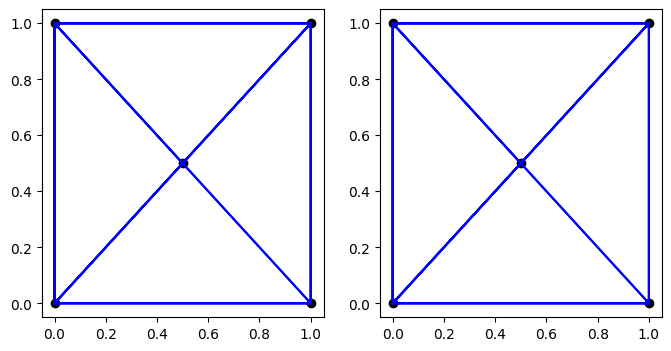

In [5]:
%%cython
#--annotate
import time
import sys
from copy import copy
import matplotlib.pyplot as plt

cimport cython
cimport numpy as np
import numpy as np

from cpython.set cimport PySet_Add

from hyperct import Complex
from hyperct._vertex import VertexCube

def connect(v0, v1):
    if v1 is not v0 and v1 not in v0.nn:
        v0.nn.add(v1)
        v1.nn.add(v0)


cdef class CythonVertex:
    cdef public set nn
    cdef public object x
    cdef public object hash

    def __init__(self, x, nn=None):
        self.x = x
        self.nn = set()
        self.hash = hash(self.x)
        if nn is not None:
            self.nn = set(nn)
        else:
            self.nn = set()

    def __hash__(self):
        return self.hash

    # Define the __getattr__ method
    def __getattr__(self, item):
        if item == 'x_a':
            return np.array(self.x)

cdef class CythonVertexCacheIndex:
    cdef public dict cache
    cdef public list cache_list
    cdef public int index
    cdef public object Vertex

    def __init__(self):
        self.cache = {}
        self.cache_list = []
        self.index = 0
        self.Vertex = CythonVertex

    def __iter__(self):
        return iter(self.cache_list)

    def get_by_index(self, x):
        return self.cache_list[x]

    def get_by_key(self, x):
        if x not in self.cache:
            xval = CythonVertex(x, index=self.index)
            self.add_item(x, xval)

        return self.cache[x]

    def add_by_key(self, key, value):
        if key not in self.cache:
            self.cache_list.append(value)
        self.cache[key] = value
        self.index += 1


cpdef CythonVertex python_to_cython_vertex(object python_vertex, cython_cache_index, set visited):
    cdef CythonVertex cython_vertex = CythonVertex(python_vertex.x)
    if cython_vertex.x not in cython_cache_index.cache.keys():
        cython_cache_index.add_by_key(cython_vertex.x, cython_vertex)

    else:
        return

    # cython_vertex.nn = set()
    queue = list()
    queue.append((python_vertex, cython_vertex))

    while queue:
        python_vertex, cython_vertex = queue.pop(0)

        if python_vertex not in visited:
            visited.add(python_vertex)

            for nn in python_vertex.nn:

                # prevent going back to neighbour it came from
                if nn not in visited:

                    # Prevent making object with new memory address
                    # Can happen if v0 is connected to v1 and v2 and v1 is connected to v0 and v2.
                    # We do not want to make a new v2 when we are visiting v1.
                    if nn.x not in cython_cache_index.cache.keys():
                        cython_vertex_nn = CythonVertex(nn.x)
                    else:
                        cython_vertex_nn = cython_cache_index.get_by_key(nn.x)
                        #cython_vertex_nn = cache[nn.x]

                    connect(cython_vertex, cython_vertex_nn)

                    # Add to q so we can visit it later
                    queue.append((nn, cython_vertex_nn))

                    # Same as above: prevent new reference
                    if nn.x not in cython_cache_index.cache.keys():
                        cython_cache_index.add_by_key(cython_vertex_nn.x, cython_vertex_nn)

        cython_cache_index.add_by_key(cython_vertex.x, cython_vertex)


    return


cpdef CythonVertexCacheIndex python_vertex_to_cython_vertex_cache(object py_vertex):
    c_vertex = CythonVertexCacheIndex()

    # Copy relevant attributes from the Python to Cython version
    visited = set()
    for key, value in py_vertex.cache.items():
        python_to_cython_vertex(value, c_vertex, visited)  # Convert and add to the cache

    c_vertex.index = py_vertex.index
    c_vertex.Vertex = py_vertex.Vertex  

    return c_vertex

# ---------------------- validate ---------------------- 

def compare_caches(cache1, cache2):

    # Check if caches have the same number of elements
    if len(cache1) != len(cache2):
        return False

    # keys are tuples, values are vertices
    for key1, value1 in cache1.items():
        # Find the corresponding key in cache2 based on the 'x_a' attribute
        corresponding_key2 = next((key2 for key2, value2 in cache2.items() if np.array_equal(value2.x_a, value1.x_a)), None)
        
        if corresponding_key2 is None:
            return False  # No corresponding key found

        # Compare values
        if key1 != corresponding_key2:
            return False

    return True

# making sure the cache python-to-cython conversion that is done correctly
D = 2
C = Complex(dim=D, domain=[(0, 1)]*D)
C.triangulate()

CythonV = python_vertex_to_cython_vertex_cache(C.V)

are_caches_same = compare_caches(C.V.cache, CythonV.cache)
print("Caches are the same:", are_caches_same)

_, ax = plt.subplots(ncols=2, figsize=(8, 4))
for v in CythonV.cache:
    ax[0].scatter(v[0], v[1], c='k')
    xlines = []
    ylines = []
    for v2 in CythonV.cache[v].nn:
        xlines.append(v2.x[0])
        ylines.append(v2.x[1])
        xlines.append(v[0])
        ylines.append(v[1])
    ax[0].plot(xlines, ylines, color='b')

for v in C.V.cache:
    ax[1].scatter(v[0], v[1], c='k')
    xlines = []
    ylines = []
    for v2 in C.V.cache[v].nn:
        xlines.append(v2.x[0])
        ylines.append(v2.x[1])
        xlines.append(v[0])
        ylines.append(v[1])
    ax[1].plot(xlines, ylines, color='b')
plt.show()
